### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Sofía Hernández Zatarain, Luis Eduardo Sánchez Soto, Cristian Vázquez Plesent.

**Fecha:** 18 de abril del 2023.

**Expediente** : 727151, 734350, 731324.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/sofiahzt/Proyecto

# Proyecto TEMA-2

___
## Desempleo en Estados Unidos.

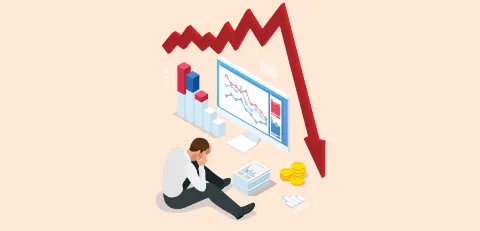

Con este proyecto buscamos analizar el comportamiento de la tasa de desempleo, el PIB, el salario minimo, poblacion e inflación en Estados Unidos a lo largo del tiempo para realizar una proyección de la poblacion desempleada en los siguientes años. 

### 1.2 Objetivos.

**Objetivo general**

Predecir la población desempleada de Estados Unidos durante la siguiente década.

**Objetivos específicos**

* Encontrar la distribución de probabilidad de la población desempleada
* Encontrar la distribución de probabilidad de la tasa de crecimiento del PIB 
* Encontrar la distribución de probabilidad de la tasa de crecimiento de la poblacion
* Encontrar la distribución de probabilidad de la tasa de crecimiento del salario minimo en Estados Unidos
* Encontrar la distribución de probabilidad de la tasa de variacion de la inflacion

### 1.3 Definición del problema.

Considerando que disponemos de un dataset sobre el desempleo en Estados Unidos por estado, haremos una agrupación de los datos en relación a los años establecidos en el frame. Posteriormente obtendrémos las distribuciones de probabilidad de nuestros nodos de interés para así iniciar con las simulaciones. 

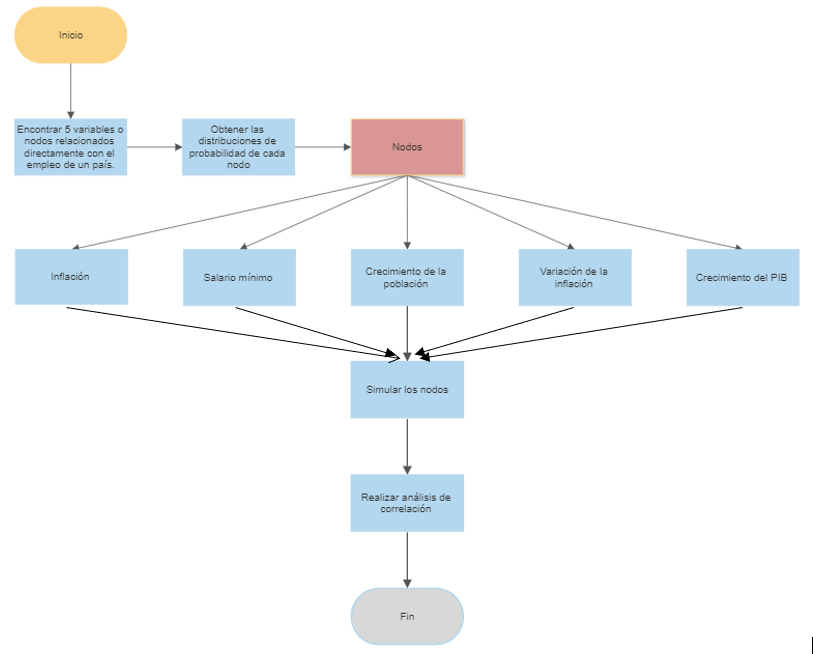

### 1.4 Nodos y variables que se decidieron simular y porqué

* Porcentaje de la fuerza de trabajo desempleada: necesitamos conocer el porcentaje de población desempleada.
* Producto Interno Bruto: indicador del desempeño de la economia, tiene relacion directa con la creacion de nuevos empleos.
* Población en Estados Unidos: si queremos predecir la poblacion desempleada, necesitaremos principalmente predecir la tasa de desempleo y la poblacion desempleada.
* Salario minimo : el salario minimo impacta directamente la demanda de empleos.
* inflacion: importante indicador de la situación economica del pais.  

### 1.5 Definición de hipótesis y supuestos.

**Hipótesis:**

La poblacion de Estados Unidos, el crecimiento de su PIB, crecimiento del salario minimo, la variacion de la inflacion y la tasa desempleada estan directamente relacionadas y pueden usarse pronosticar la poblacion desempleada del pais.

**Supuestos:**

* No sucederán eventos que impacten desproporcionadamente la tasa de desempleo (pandemia, guerras, crisis)

### 1.6 Obtención de bases de datos

https://www.kaggle.com/datasets/justin2028/unemployment-in-america-per-us-state
https://www.kaggle.com/discussions/general/162174
https://www.kaggle.com/datasets/alexandrepetit881234/us-population-by-state
https://www.kaggle.com/datasets/lislejoem/us-minimum-wage-by-state-from-1968-to-2017
https://datos.bancomundial.org/indicador/FP.CPI.TOTL.ZG?locations=US

In [224]:
#Cargamos los datasets y los limpiamos y/o ajustamos

# Obtenemos el Tasa de la fuerza laboral activa desempeada en Estados unidos
desempleo = pd.read_csv("Unemployment.csv")
desempleo_corr = desempleo.groupby('Year').mean()["Percent (%) of Labor Force Unemployed in State/Area"].iloc[:45]
desempleo = desempleo["Percent (%) of Labor Force Unemployed in State/Area"]

#Obtenemos el salario minimo en cada Estado por año, deflactado a dolares de 2020
wage = pd.read_csv("Minimum Wage Data.csv",encoding='cp1252')
wage_corr = wage.groupby('Year').mean() 
wage_corr = wage_corr["State.Minimum.Wage.2020.Dollars"][8:].rename(index=dict(zip(range(26, 71), range(1976,2021))))
wage = wage.drop(wage[wage["State.Minimum.Wage.2020.Dollars"] == 0].index)
wage = wage["State.Minimum.Wage.2020.Dollars"]

#Cargamos el dataset del PIB y obtenemos los rendimientos de este 
gdp = pd.read_csv("gdp.csv")
gdp = gdp[gdp["Country Name"]=="United States"].drop(columns=["Country Name", "Code","Unnamed: 65"])
gdp = gdp.iloc[:, 1:].transpose()
gdp['Rendimiento'] = gdp[251].pct_change()
gdp_corr = gdp["Rendimiento"].iloc[15:].rename(index=dict(zip(range(26, 71), range(1976,2021))))

#Cargamos el cambio porcentual respecto al año anterior de la poblacion de Estados Unidos
popu = pd.read_csv("pop_us.csv")
popu_corr = pd.DataFrame(popu.iloc[26:-80])
popu_corr = popu_corr.iloc[:,2]
popu_corr = popu_corr.rename(index=dict(zip(range(26, 71), range(1976,2021))))
popu = popu.drop(0)
popu = popu.iloc[:-78]
pop = popu.iloc[:, 2]

#Cargamos la inflacion anual resgitrada en Estados Unidos
inf = pd.read_csv("inflacion.csv")
inf = inf[inf["Country Name"]=="Estados Unidos"].drop(columns=["Country Name", "Country Code","Indicator Name", "Indicator Code"]).transpose()
inf_corr = inf.iloc[16:61]
inf_corr = pd.Series(inf_corr[251]).rename(index=dict(zip(range(26, 71), range(1976,2021))))

In [229]:
# convertir arrays en DataFrames
df1 = pd.DataFrame(desempleo_corr)
df2 = pd.DataFrame(wage_corr)
df4 = pd.DataFrame(popu_corr)
df3 = pd.DataFrame(gdp_corr)
df5 = pd.DataFrame(inf_corr)

# concatenar DataFrames
df_concatenado_2 = pd.concat([df1, df2, df4], axis=1)
df_concatenado_2.index =  range(1976,2021)
df_concatenado_1 = pd.concat([df3, df5], axis=1)
df_concatenado_1.index =  range(1976,2021)
df_concatenado = pd.concat([df_concatenado_1, df_concatenado_2], axis=1)
df_concatenado = df_concatenado.rename(columns={'Rendimiento': 'PIB %',
                        251: 'Inflacion %',
                        'Percent (%) of Labor Force Unemployed in State/Area': 'Desempleo %', 
                                               'State.Minimum.Wage.2020.Dollars': 'Salario Min.',
                                               'Change': 'Poblacion %'})
df_concatenado

,PIB %,Inflacion %,Desempleo %,Salario Min.,Change
1976,0.111881,5.744813,7.166195,7.043519,0.94
1977,0.111248,6.501684,6.678145,6.614074,1.02
1978,0.129585,7.630964,5.730503,6.146481,1.13
1979,0.117254,11.254471,5.565094,7.009444,1.18
1980,0.087531,13.549202,6.843868,6.566481,1.21
1981,0.122400,10.334715,7.298270,6.354815,1.13
1982,0.042640,6.131427,9.203774,5.986667,1.04
1983,0.086802,3.212435,9.177201,5.800370,1.05
1984,0.111054,4.300535,7.302044,5.561296,1.03
1985,0.074640,3.545644,7.052987,5.369074,1.02


In [230]:
df_concatenado.corr()

,PIB %,Inflacion %,Desempleo %,Salario Min.,Change
PIB %,1.000000,0.694903,-0.012277,-0.413785,0.364453
Inflacion %,0.694903,1.000000,0.149781,-0.252292,0.341696
Desempleo %,-0.012277,0.149781,1.000000,-0.110865,-0.035692
Salario Min.,-0.413785,-0.252292,-0.110865,1.000000,-0.652039
Change,0.364453,0.341696,-0.035692,-0.652039,1.000000


### 1.7 Visualización de resultados de simulación.
> Se deben simular al menos 4  "nodos" o "escenarios" en tu problema. Para la segunda entrega debes haber elaborado un programa que simule dos de ellos, los primeros dos de tu diagrama.
> Para la entrega final deben de tener los 4 nodos con todas sus simulaciones.

In [1]:
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm 

In [238]:
def best_dist( nodo:"Variable a la cual se desea ajustar una distribucion estadistica continua existente"):
    """
    
    Esta función recibe sólo una variable, a la cual ajusta las primeras 20 distribuciones continuas que 
    contiene el paquete scipy. Se comparan las distribuciones contra nuestros datos y ee crea un dataFrame para 
    registrar el error cuadrático promedio,se ordena el dataframe de menor a mayor, se almacenan los primeros 5 valores y se 
    crea una lista de estas distribuciones. Por último, itera sobre la lista de distribuciones mejor ajustadas y se grafican
    las funciones de densidad de probabilidad sobre el histograma para mostrar la comparacion visual. Se almacenan los 
    parámetros de estas funciones en una lista.
    Esta función regresa la distribución con menor error y sus parámetros, en dos variables.
    """
    y,x,_ = plt.hist(nodo,bins="auto",density=True)
    x = x[1:]
    
    dist = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st,"rv_continuous"))]
    dist = dist[0:20]
    error = pd.DataFrame(index = dist, columns=["distribucion", "error"])
    i=0
    
    for d in dist:
        param = getattr(st,d).fit(nodo)
        y_hat = getattr(st,d).pdf(x,*param)
        error.loc[d] = ((y - y_hat)**2).mean()
    menor_error = error.sort_values(by="error")
    menor_error = menor_error[0:5]
    dists_menor_error = menor_error.index
    distribucion_menor_error = []
    parametros = []
    for d in dists_menor_error:
        distribucion_menor_error.append(getattr(st,d))
        param = getattr(st,d).fit(nodo)
        y_hat = getattr(st,d)(*param).pdf(x)
        parametros.append(param)
        plt.plot(x,y_hat,label=d)
    plt.legend()
    return distribucion_menor_error[0], parametros[0]

In [239]:
def Q_Q(nodo: "Variable a la que intentamos ajustar una distribucion", distribucion: "Nombre de la distribucion continua que se compara con los datos", parametros: "Parametros de la distribucion"):
    measurements = nodo   
    divisiones = 30 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2,1, figsize=(8,8))
    fig.tight_layout(pad=3.0)

    y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Histograma mediciones')

    # Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
    dist = distribucion
    params = getattr(st, dist).fit(measurements)

    # Graficar PDF de la distribución que queremos probar

    # x = np.arange(measurements.min(), measurements.max(), .01)
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()

    # gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
    # Usando scipy
    grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title('Usando paquete scipy')

    # plt.xlabel(f'{dist.title()} theorical quantiles')
    # plt.ylabel('Data theorical quantiles')
    plt.show()



#### Nodos

#### desempleo

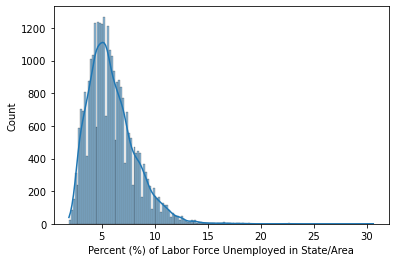

In [3]:
sns.histplot(desempleo,kde=True);

In [4]:
desempleo

0         6.6
1         7.1
2        10.2
3         7.3
4         9.2
         ... 
29887     3.1
29888     4.5
29889     4.1
29890     3.0
29891     3.9
Name: Percent (%) of Labor Force Unemployed in State/Area, Length: 29892, dtype: float64

(2.227719673153541, 4.480210121607424, 1.8659489032230234, 8.303027431457283)

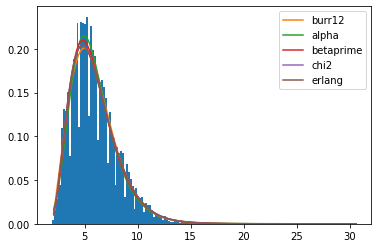

In [240]:
d,p = best_dist(desempleo)
p

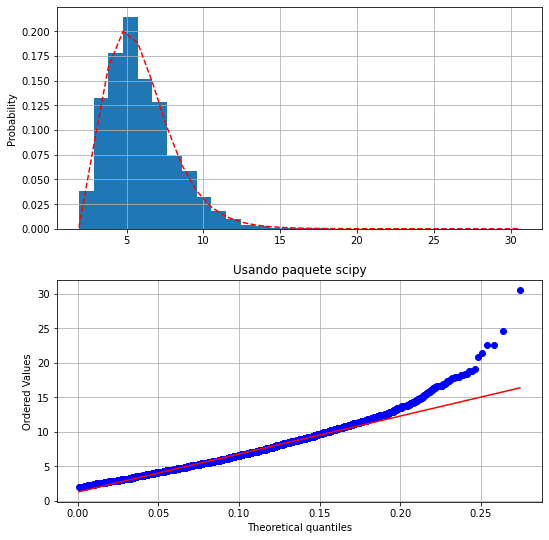

In [241]:
dist="burr12"
Q_Q(desempleo, dist, p)

#### Salario minimo

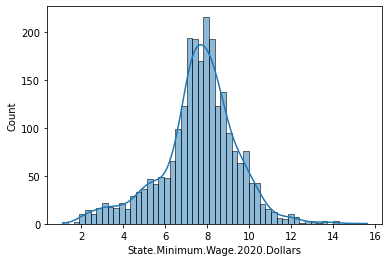

In [242]:
sns.histplot(wage, kde=True);

In [243]:
wage

1       15.61
2        3.48
3        1.16
4       12.26
5        7.43
        ...  
2857     7.25
2858    13.50
2859     8.75
2860     7.25
2861     5.15
Name: State.Minimum.Wage.2020.Dollars, Length: 2432, dtype: float64

(1.1102406204764472, 7.710151784804342, 1.2201665654629594)

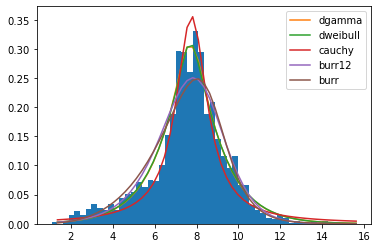

In [244]:
d,p = best_dist(wage)
p

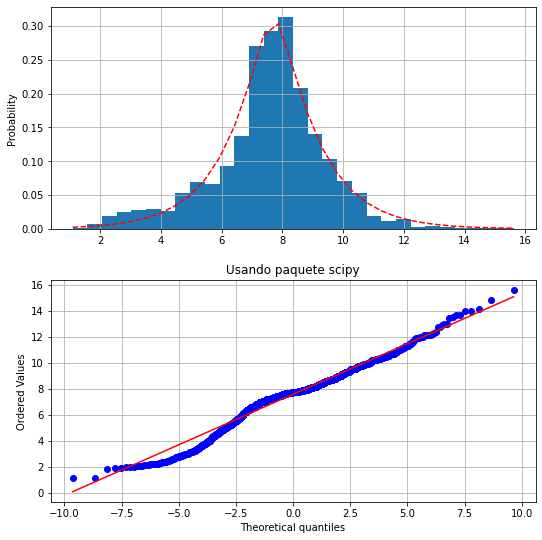

In [11]:
dist="dgamma"
Q_Q(wage,dist,p)

#### crecimiento del PIB

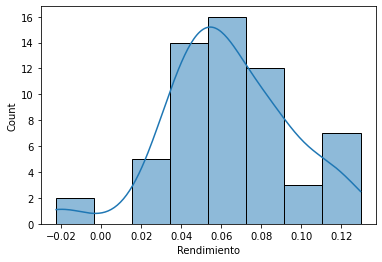

In [248]:
sns.histplot(gdp['Rendimiento'],kde=True);

In [249]:
gdp=gdp['Rendimiento'][1:]

(2069.7093485112573,
 210.56733639710876,
 -4.475712633112741,
 5.0011862913466505)

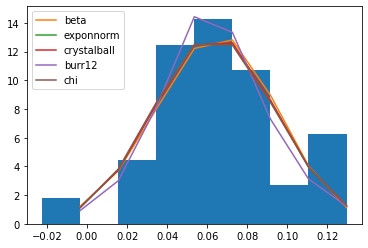

In [250]:
d,p = best_dist(gdp)
p

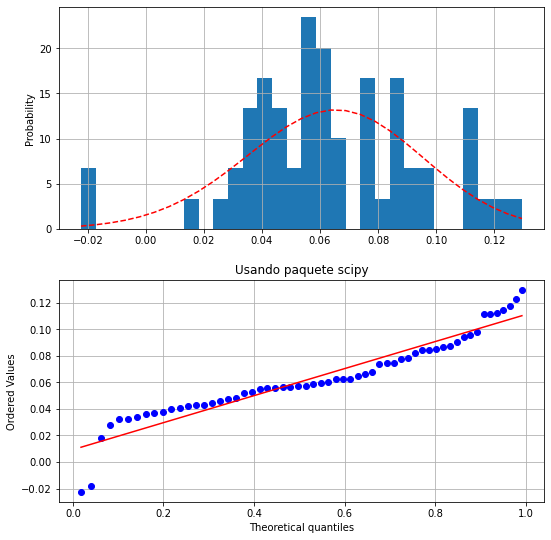

In [251]:
dist="beta"
Q_Q(gdp,dist,p)

#### Poblacion

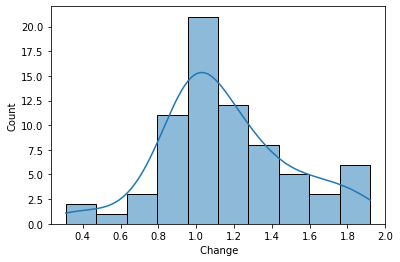

In [252]:
sns.histplot(pop, kde=True);

(7964.7387142787775,
 0.5559986202602145,
 -1128.6833630958586,
 1129.6714857420661)

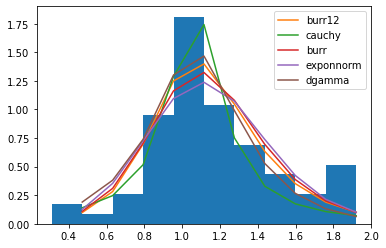

In [253]:
d,p = best_dist(pop)
p

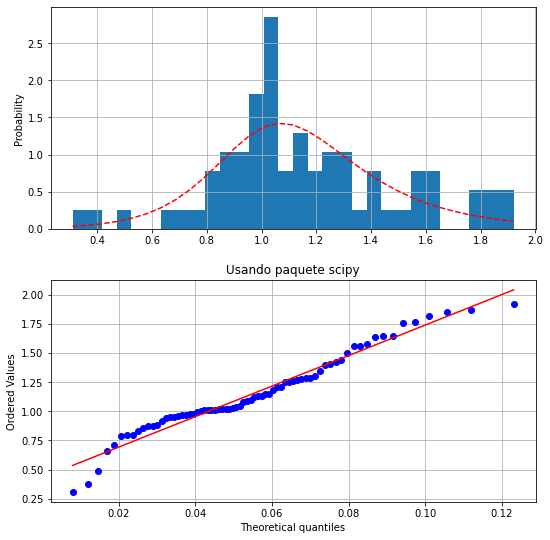

In [254]:
dist="burr12"
Q_Q(pop,dist,p)

#### Inflación

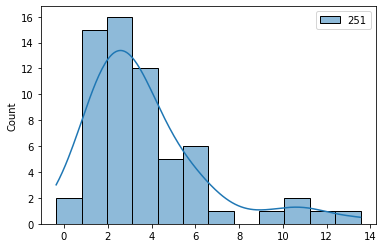

In [255]:
sns.histplot(inf,kde=True);

(3.8886572605513727,
 2.0139383107821436,
 -2.4326978306349414,
 4.347947760356947)

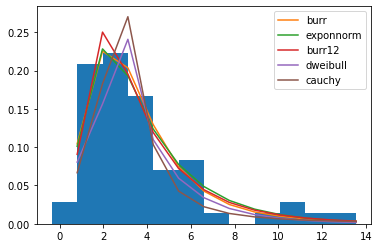

In [256]:
d,p = best_dist(inf)
p

In [261]:
pop

1     1.56
2     1.56
3     1.64
4     1.77
5     1.85
      ... 
68    0.71
69    0.66
70    0.49
71    0.31
72    0.38
Name:  Change, Length: 72, dtype: float64

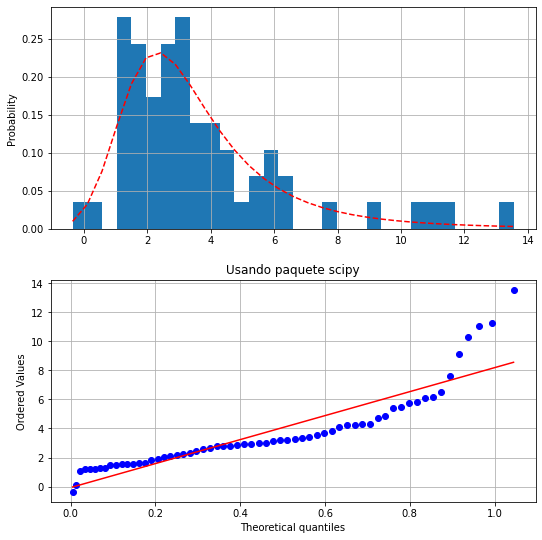

In [264]:
dist="burr"
Q_Q(inf[251],dist,p)

___
## 2. Especificaciones adicionales.
En el grupo deben haber mínimo dos integrantes y máximo tres integrantes. Para propósitos logísticos nada más, por favor enumérense como *integrante 1*, *integrante 2* e *integrante 3*.

### 2.1 Notebook de jupyter. 
> Los anteriores numerales los deben desarrollar todos en un notebook de jupyter y llamarlo de la siguiente manera `ProyectoModulo1_ApellidoN1_ApellidoN2_ApellidoN3`, donde `ApellidoNi` hace referencia al apellido materno y la inicial del primer nombre del integrante `i`.

### 2.2 Proyecto en `GitHub`.
> El integrante 1 deberá crear un proyecto en `GitHub` llamado **proyecto_modulo1**, donde tendrán todos los archivos relacionados con el proyecto. Los demás integrantes deben hacer un *fork* del proyecto, seguir el proyecto principal con `GitKraken` y hacer al menos dos contribuciones con *pull request* (como se hizo en la tarea). En el proyecto, deben incluir el repositorio remoto del integrante 1.

### 2.3 Presentación.
> Recuerden que la nota del proyecto es mitad el trabajo, y mitad la presentación. Deben hacer una presentación ya sea en power point o utlizando un notebook de python para presentar el trabajo durante un horario de clase que se será posteriomente definido. La presentación, además de llevar todos los componentes básicos descritos en el entregable, debe llevar una tabla de contenido.
> - Presentación: 10 minutos.
> - Seguir estas recomendaciones: https://es.slideshare.net/MeireComputacion/power-point-pautas-para-una-buen-trabajo

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>